import the relevant modules we will need for our strategy backtest

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.style.use('bmh')
import matplotlib.pylab as plt
from datetime import datetime, timedelta
import statsmodels.api as sm
from pykalman import KalmanFilter
from math import sqrt
import time 

C:\Users\sarac\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Download set 100 data and drop TOA symbol 

In [2]:
set100 = pd.read_csv("SET100_symbol.csv")
stock_list = set100['RIC']
stocks = [symbol for symbol in stock_list if symbol != "TOA.BK"]    # Drop TOA
set100

,RIC,Name
0,CPN.BK,CENTRAL PAT
1,KBANK.BK,KASIKORNBANK
2,ADVANC.BK,ADVANCED INFO SV
3,LH.BK,LAND & HOUSE
4,BGRIM.BK,B.GRIMM POWER
5,SCB.BK,SIAM COM BANK
6,STA.BK,SRI TRANG AGRO
7,MEGA.BK,MEGA LIFE
8,ERW.BK,ERAWAN GROUP
9,MINT.BK,MINOR INTERNAT


In [8]:
#not all stocks will return data so set up an empty list to store the stock tickers that actually successfully returns data
used_stocks = []

Download the data to DataFrame 

In [12]:
df = pd.DataFrame()
not_success = True 
while not_success :
    import fix_yahoo_finance as yf
    for stock in stocks:
        try:
            print("Download Stock Name : " + stock )
            data = yf.download(stock, start='2014-01-01', end='2017-06-01')
            df[stock] = np.array(data["Close"])
            if data.shape[0] > 5: 
                used_stocks.append(stock)
                not_success = False 
            else : 
                print("Recieved Nan data")
        except: 
            print("Cannot download :" + stock)
            time.sleep(2)
print("Download End !")

Download Stock Name : CPN.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : KBANK.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : ADVANC.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : LH.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : BGRIM.BK
[*********************100%***********************]  1 of 1 downloaded
Cannot download :BGRIM.BK
Download Stock Name : SCB.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : STA.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : MEGA.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : ERW.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : MINT.BK
[*********************100%********************

[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : GFPT.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : TPIPP.BK
[*********************100%***********************]  1 of 1 downloaded
Cannot download :TPIPP.BK
Download Stock Name : BLA.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : SPRC.BK
[*********************100%***********************]  1 of 1 downloaded
Cannot download :SPRC.BK
Download Stock Name : SIRI.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : AP.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : BANPU.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : PSL.BK
[*********************100%***********************]  1 of 1 downloaded
Download Stock Name : KTC.BK
[*********************100%***********************]  

Lets plot the resulting DataFrame of price data just to make sure we have what we need and as a quick sanity check:

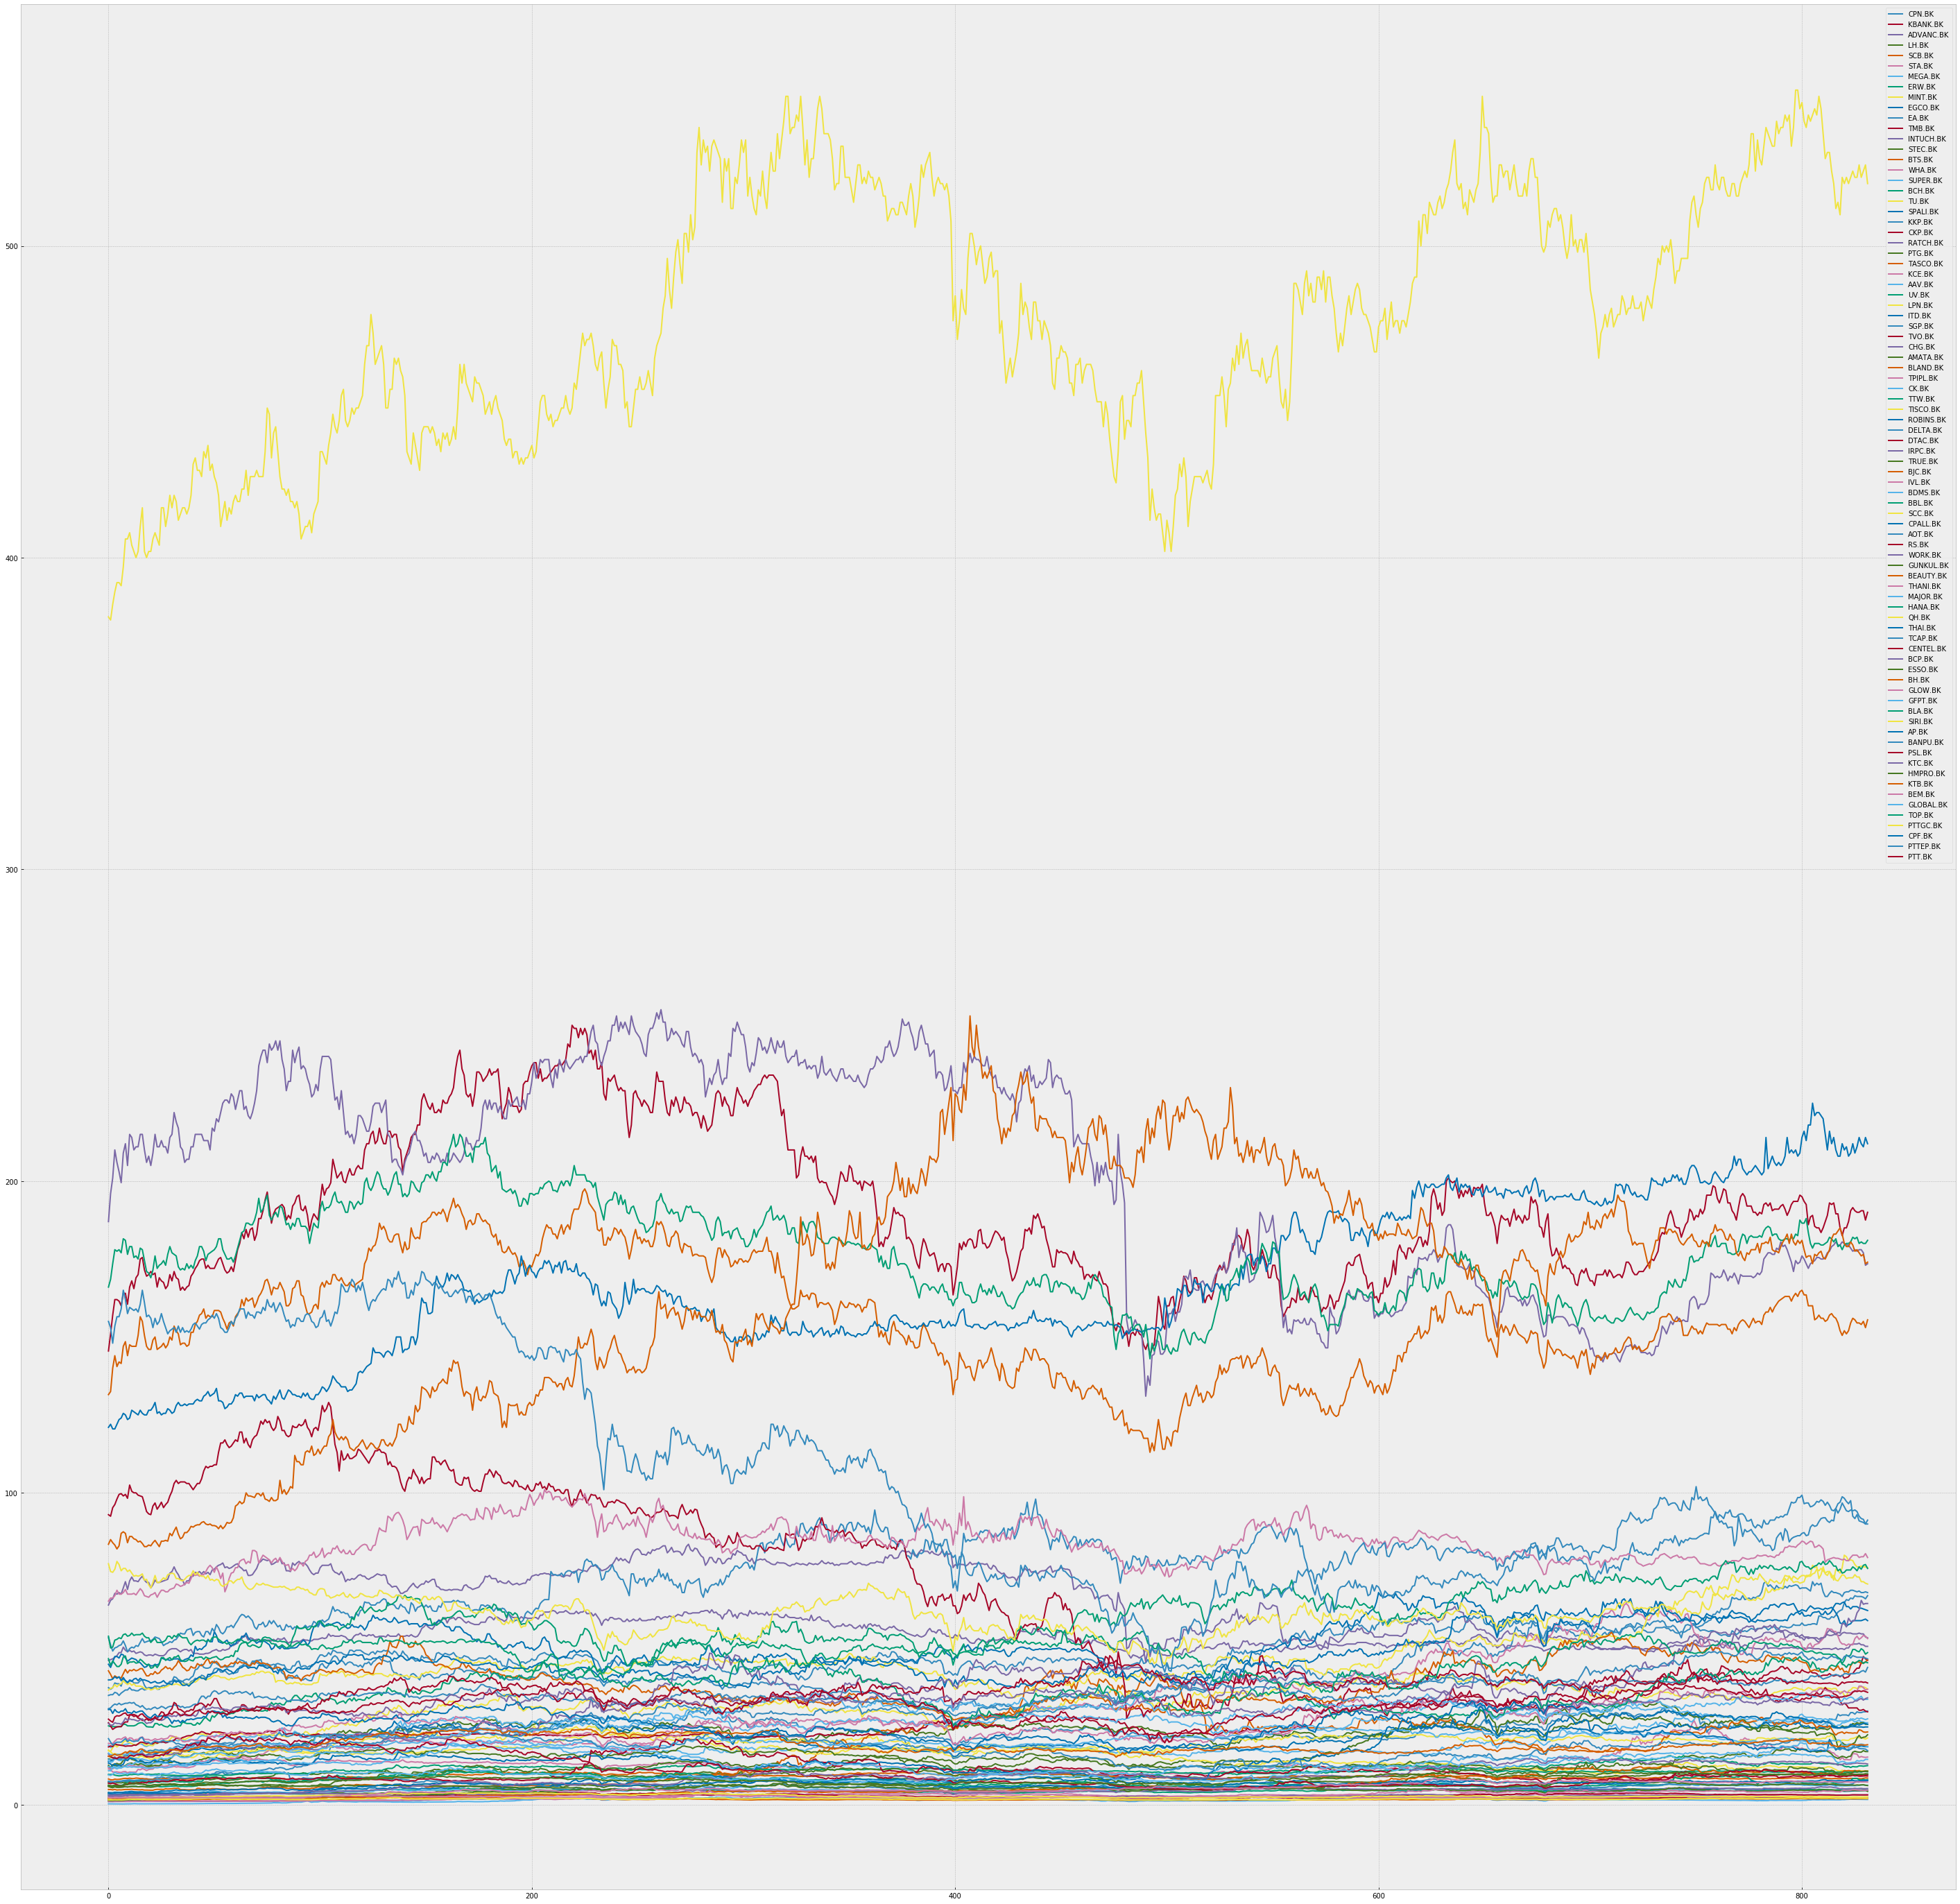

In [24]:
df = df.dropna(axis=1)
df.plot(figsize=(50,50))

We will now define a quick function that will run our stocks, combining them into pairs one by one and running co-integration tests on each pair. That result will then be stored in a matrix that we initialise,
and then we will be able to plot that matrix as a heatmap. Also, if the co-integration test meets our threshold statistical significance (in our case 5%), then that pair of stock tciokers will be stored in a list for later retrieval.

In [25]:
#NOTE CRITICAL LEVEL HAS BEEN SET TO 5% FOR COINTEGRATION TEST
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]] # obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue <= critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs

Let’s now run our data through our function, save the results and plot the heatmap:

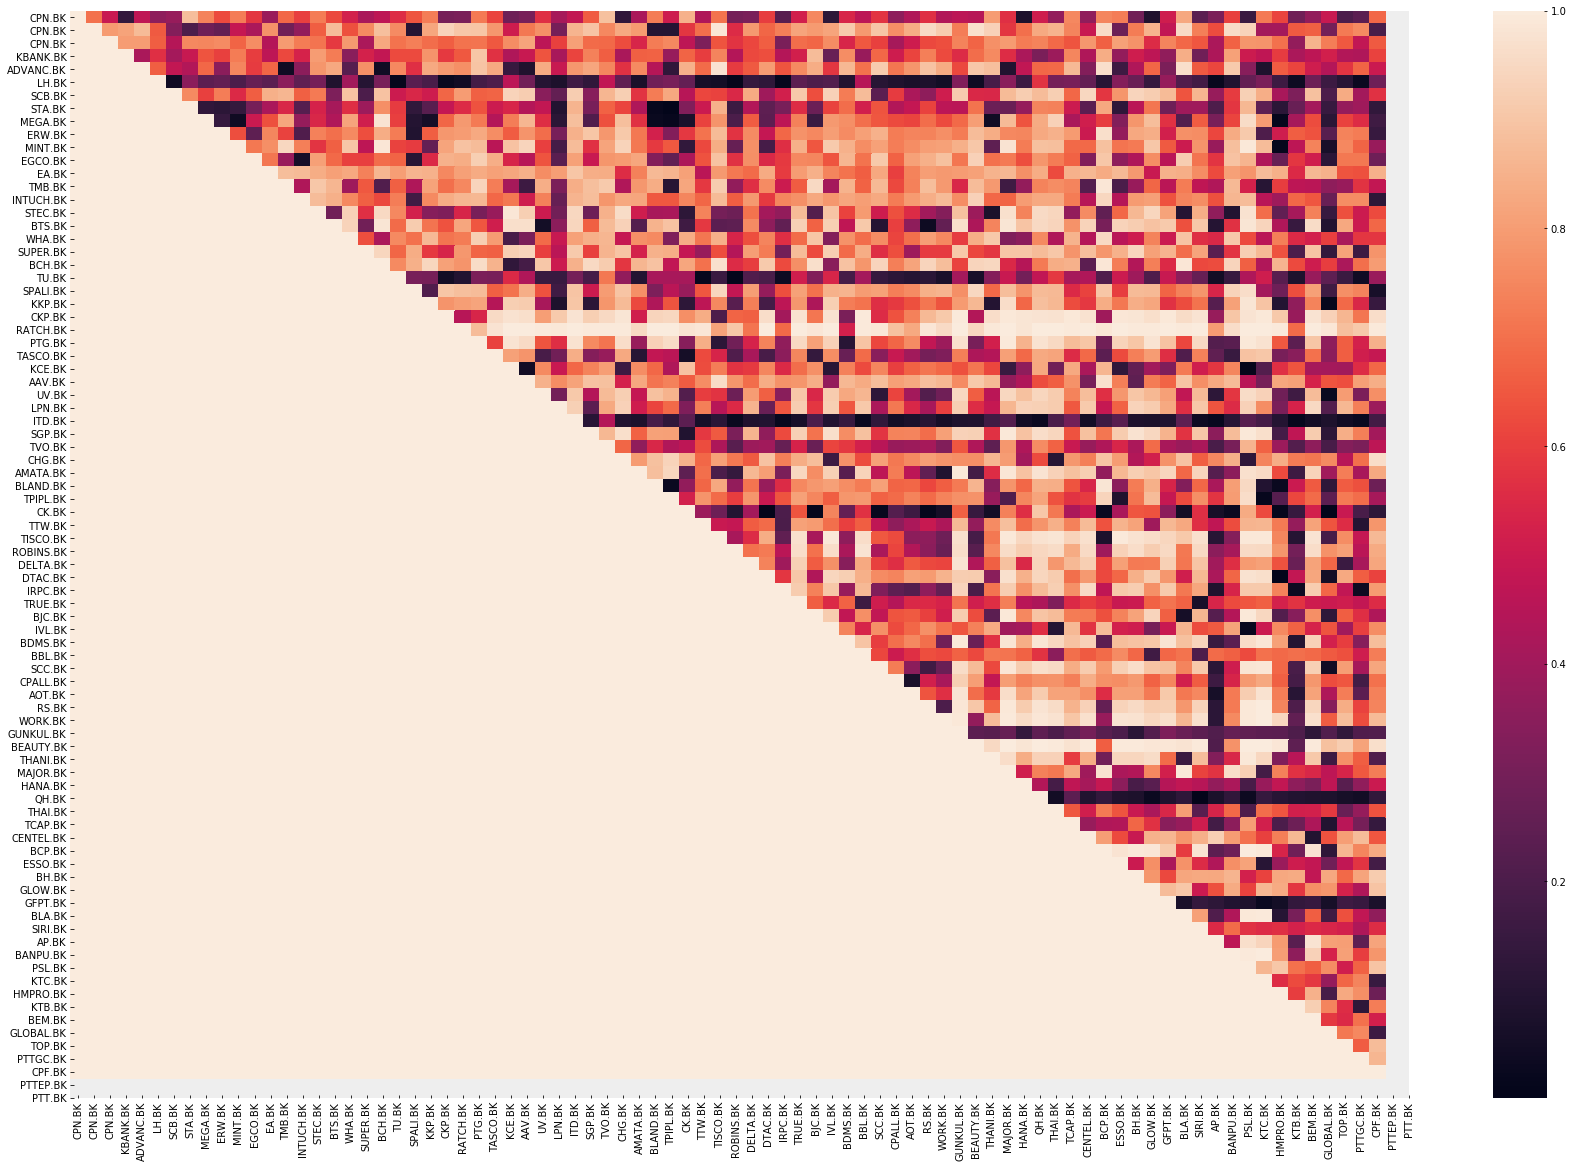

In [29]:
#set up the split point for our "training data" on which to perform the co-integration test (the remaining dat awill be fed to our backtest function)
split = int(len(df) * .4)

#run our dataframe (up to the split point) of ticker price data through our co-integration function and store results
pvalue_matrix,pairs = find_cointegrated_pairs(df[:split])

#convert our matrix of stored results into a DataFrame
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

#use Seaborn to plot a heatmap of our results matrix
fig, ax = plt.subplots(figsize=(60,40))
sns.heatmap(pvalue_matrix_df,xticklabels=used_stocks,yticklabels=used_stocks,ax=ax);

So we can see from the very dark red squares that it looks as though there are indeed a few pairs of stocks who’s co-integration score is below the 5% threshold
hardcoded into the function we defined. To see more explicitly which pairs these are, let’s print out our list of stored pairs that was part of the fucntion results we stored:

In [30]:
for pair in pairs:
    print("Stock {} and stock {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))

Stock SCB.BK and stock STEC.BK has a co-integration score of 0.0427
Stock SCB.BK and stock SPALI.BK has a co-integration score of 0.0479
Stock STA.BK and stock MEGA.BK has a co-integration score of 0.0414
Stock STA.BK and stock KKP.BK has a co-integration score of 0.0144
Stock STA.BK and stock PTG.BK has a co-integration score of 0.0248
Stock STA.BK and stock TASCO.BK has a co-integration score of 0.045
Stock STA.BK and stock DTAC.BK has a co-integration score of 0.0094
Stock STA.BK and stock BJC.BK has a co-integration score of 0.019
Stock STA.BK and stock MAJOR.BK has a co-integration score of 0.0409
Stock STA.BK and stock PSL.BK has a co-integration score of 0.0244
Stock STA.BK and stock GLOBAL.BK has a co-integration score of 0.0385
Stock STA.BK and stock PTTEP.BK has a co-integration score of 0.0286
Stock ERW.BK and stock CK.BK has a co-integration score of 0.0191
Stock ERW.BK and stock TTW.BK has a co-integration score of 0.0012
Stock MINT.BK and stock EA.BK has a co-integration 

We will now use the “pykalman” module to set up a couple of functions that will allow us to generate Kalman filters which we will apply to our data and in turn our regression that is fed the said data.

I will also define a function for “Halflife” which just recycles some tof the code from my mean reversion pairs trading blog post from a couple of years ago, which can be found
here.

In [32]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
 
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
 
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
 
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
 
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
 
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
 
    if halflife <= 0:
        halflife = 1
    return halflife

Now let us define our main “Backtest” function that we will run our data through. The fucntion takes one pair of tickers at a time, and then returns several outputs, namely the DataFrame of cumulative returns,
the Sharpe Ratio and the Compound Annual Growth Rate (CAGR). Once we have defined our function, we can iterate over our list of pairs and feed the relevant data, pair by pair, into the function, storing the outputs for each pair for
later use and retrieval.

In [33]:
def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate

    x = df[s1]
    y = df[s2]

    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))

    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    # calculate half life
    halflife = half_life(df1['spread'])

    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    df1 = df1.iloc[halflife:,:]
    ##############################################################
    # trading logic
    entryZscore = 2
    exitZscore = 0
    
    #set up num units long
    df1['long entry'] = ((df1.zScore < -entryZscore) & ( df1.zScore.shift(1) > -entryZscore))
    df1['long exit'] = ((df1.zScore > -exitZscore) & (df1.zScore.shift(1) < -exitZscore)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    ##############################################################

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    ##############################################################
    start_val = 1
    end_val = df1['cum rets'].iat[-1]

    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name

    days = (end_date - start_date)
    CAGR = np.power((end_val/start_val),(252/days)) - 1
    CAGR = round(CAGR,4)

    df1[s1+ " "+s2] = df1['cum rets']

    return df1[s1+" "+s2], sharpe, CAGR

So now let’s run our full list of pairs through our Backtest function, and print out some results along the way, and finally after storing the equity curve for each pair,
produce a chart that plots out each curve.

C:\Users\sarac\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sarac\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The pair SCB.BK and STEC.BK produced a Sharpe Ratio of 0.82 and a CAGR of 0.0263
The pair SCB.BK and SPALI.BK produced a Sharpe Ratio of 0.0 and a CAGR of 0.0
The pair STA.BK and MEGA.BK produced a Sharpe Ratio of 1.14 and a CAGR of 0.017
The pair STA.BK and KKP.BK produced a Sharpe Ratio of 2.92 and a CAGR of 0.3382
The pair STA.BK and PTG.BK produced a Sharpe Ratio of 1.5 and a CAGR of 0.1834
The pair STA.BK and TASCO.BK produced a Sharpe Ratio of 1.38 and a CAGR of 0.2474
The pair STA.BK and DTAC.BK produced a Sharpe Ratio of 1.65 and a CAGR of 0.2086
The pair STA.BK and BJC.BK produced a Sharpe Ratio of 1.77 and a CAGR of 0.1851
The pair STA.BK and MAJOR.BK produced a Sharpe Ratio of 1.54 and a CAGR of 0.1378
The pair STA.BK and PSL.BK produced a Sharpe Ratio of 0.0 and a CAGR of 0.0
The pair STA.BK and GLOBAL.BK produced a Sharpe Ratio of 0.0 and a CAGR of 0.0
The pair STA.BK and PTTEP.BK produced a Sharpe Ratio of 0.77 and a CAGR of 0.0624
The pair ERW.BK and CK.BK produced a Sha

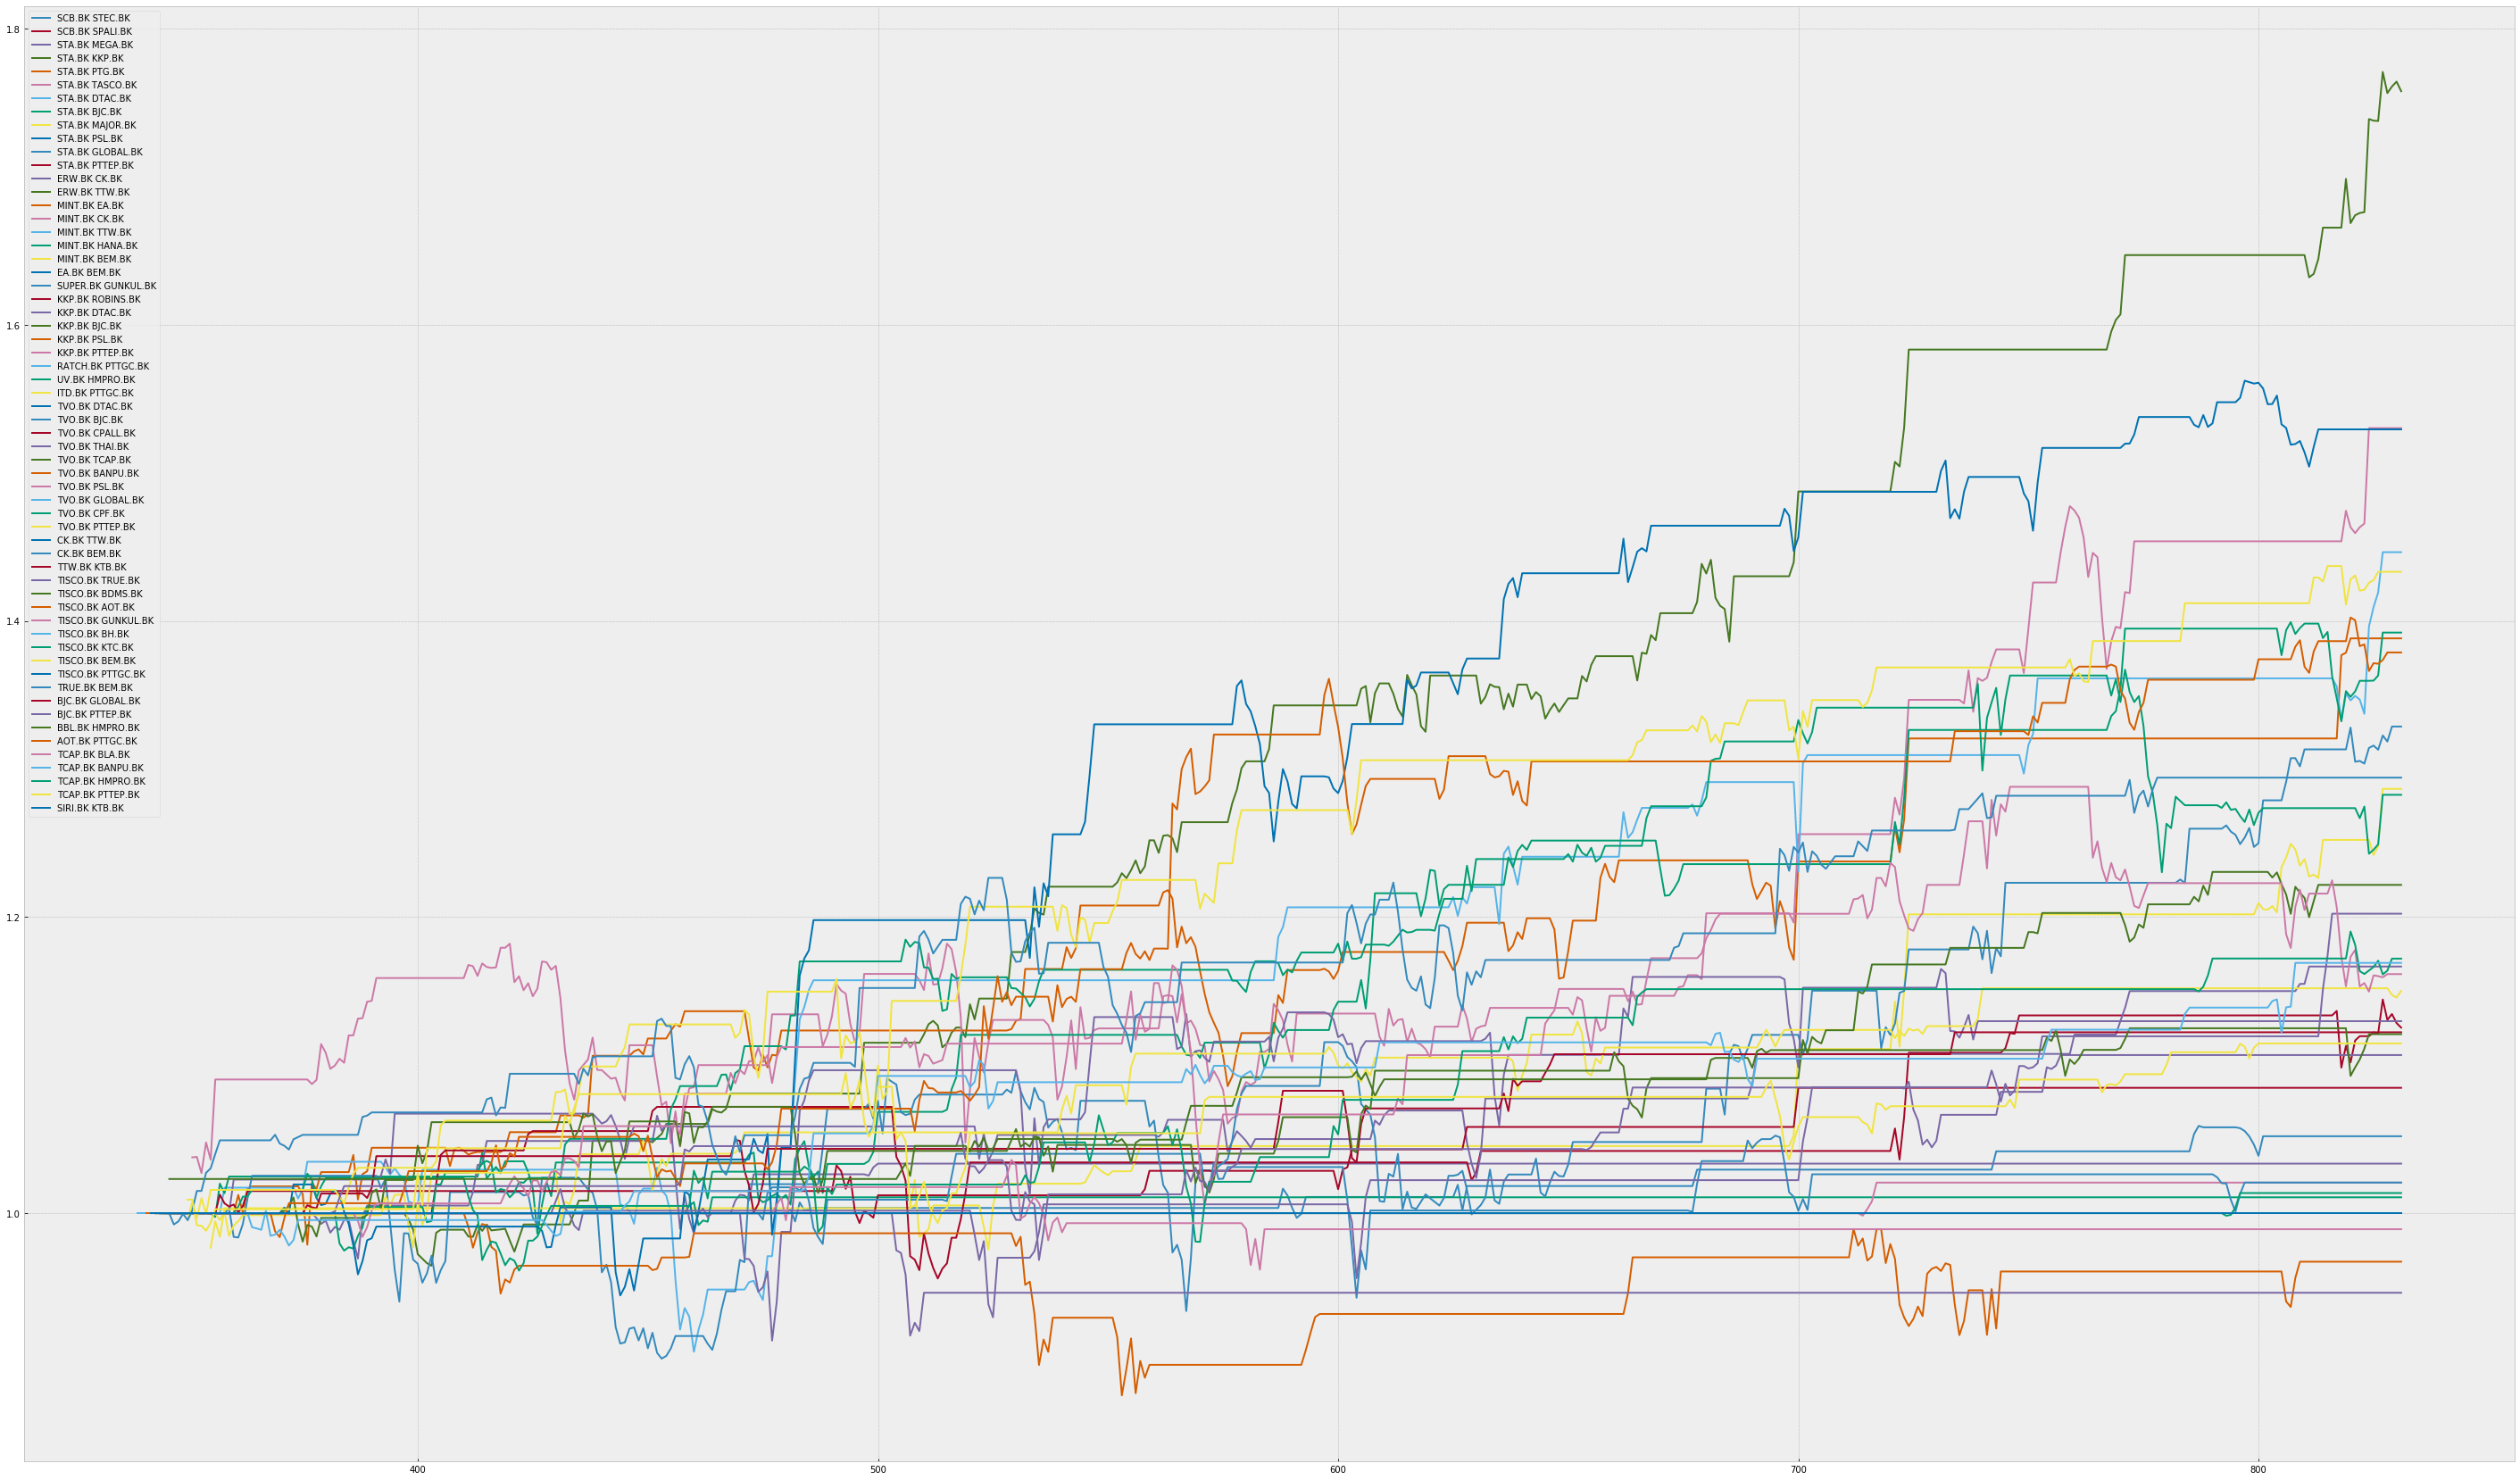

In [36]:
results = []
for pair in pairs:
    rets, sharpe, CAGR = backtest(df[split:],pair[0],pair[1])
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
    rets.plot(figsize=(50,30),legend=True)

Now we run a few extra lines of code to combine, equally weight, and print our our final equity curve:

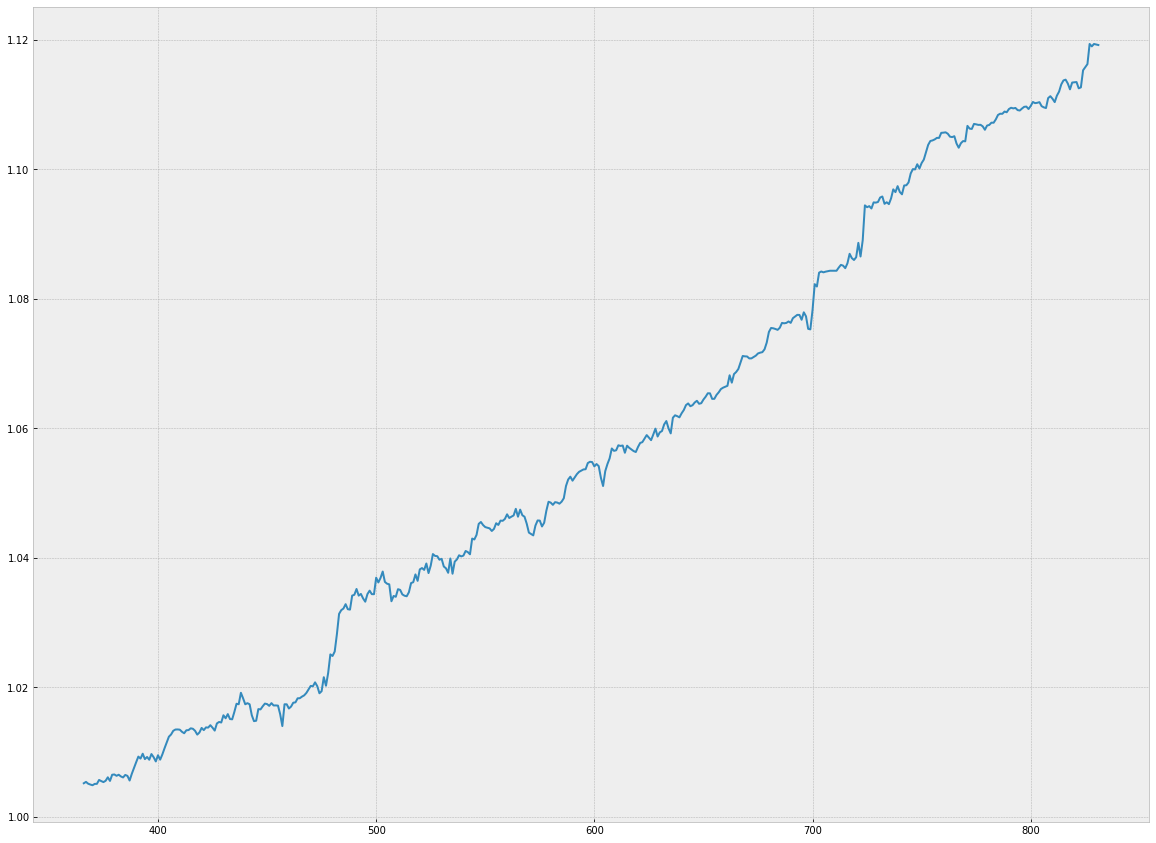

In [37]:
#concatenatge together the individual equity curves into a single DataFrame
results_df = pd.DataFrame()
for i, l in enumerate(results) :
    results_df[str(i)]=l

results_df = results_df.dropna(axis=0)
#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)
 
#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)
 
#plot the chart of our final equity curve
final_res.plot(figsize=(20,15))

In [38]:
#calculate and print our some final stats for our combined equity curve
sharpe = (final_res.pct_change().mean() / final_res.pct_change().std()) * (sqrt(252))
start_val = 1
end_val = final_res.iloc[-1]

start_date = final_res.index[0]
end_date = final_res.index[-1]

days = (end_date - start_date)

CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
print("Sharpe Ratio is {} and CAGR is {}".format(round(sharpe,2),round(CAGR,4)))


Sharpe Ratio is 4.4 and CAGR is 0.0629
